# Indian Liver Patient Dataset

### Introduction

The liver is an organ present only in vertebrates, detoxifies various metabolites, synthesizes proteins, and produces biochemicals necessary for digestion (1, 2). Liver disease is hard to be diagnosed in an early stage as the organ will be functioning normally even when it is partially damaged. An early diagnosis of liver issues with laboratory analysis of a range of proteins in the bloodstream will increase patients survival rate and reduce the waiting times to access medical care.
In the chosen dataset each instance represents a patient with a range of medical tests known to assess the onset of a broad range of liver diseases.

The data was recorded in the Andhra Pradesh state of India (3, 4). Contains 583 instances with 11 features, including the Class feature to be predicted. It contains 441 male patient records and 142 female patient records. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report,confusion_matrix

# Oversampling 
from imblearn.over_sampling import SMOTE

#scaling
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00225/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv'

columns = ['age', 'sex', 't_bilirubin', 'd_bilirubin', 'alkphos', 'sgpt', 'sgot', 't_protein', 'alb', 'alb/glob', 'class']

df = pd.read_csv(url, header=None, names = columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
age            583 non-null int64
sex            583 non-null object
t_bilirubin    583 non-null float64
d_bilirubin    583 non-null float64
alkphos        583 non-null int64
sgpt           583 non-null int64
sgot           583 non-null int64
t_protein      583 non-null float64
alb            583 non-null float64
alb/glob       579 non-null float64
class          583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


# Data Cleansing & Preprocessing


In [3]:
df.describe()

,age,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,class
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


The average instance has 45 years old and is of male gender. Apparently, maximum values for Direct Bilirubin, Alkaline Phosphatase, SGPT and SGOT are outliers in the dataset, probably because of data recording or transcribing, since their values are more than 3 standard deviations from the mean. The dataset contains 416 liver patient records and 167 non liver patient records, showing a heavy skew towards the positive class.

In [4]:
sex_mapping = {'Female': 0,'Male': 1}
df['sex'] = df['sex'].map(sex_mapping)

# mean < 1.5 
# liver patients are the majority class
# patient = 1 & non-patient = 2

class_mapping = {2 : 0, 1 : 1} 
df['class'] = df['class'].map(class_mapping)

df.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


### Taking care of NA values

In [5]:
df.isnull().values.any()

True

In [6]:
df.isnull().sum()

age            0
sex            0
t_bilirubin    0
d_bilirubin    0
alkphos        0
sgpt           0
sgot           0
t_protein      0
alb            0
alb/glob       4
class          0
dtype: int64

### Imputing "Alb/Glob" NA values with its median

In [7]:
df["alb/glob"].fillna(df.groupby('class')["alb/glob"].transform('median'), inplace=True)
df.isnull().values.any()

False

# Exploratory Data Analysis

In [8]:
plt.rcParams['figure.figsize']=(10,5)

Text(0.5, 1.0, 'Correlation Matrix for Liver Patient Dataset')

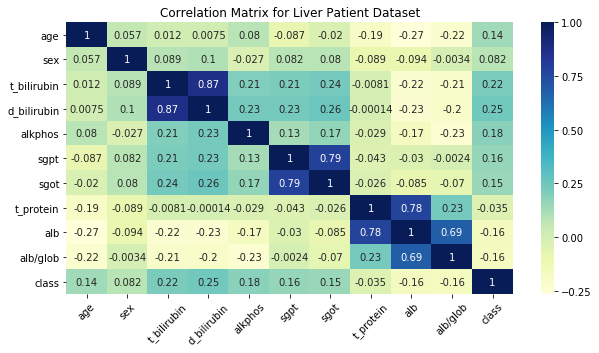

In [9]:
corr = df.corr()
ax = sns.heatmap(corr, annot = True, cmap="YlGnBu")     
plt.setp(ax.axes.get_xticklabels(), rotation=45)

plt.title('Correlation Matrix for Liver Patient Dataset')

The correlation matrix shows how each feature correlates with the onset of liver diseases. Although some correlations are distinguishable, these are not particularly strong. It’s possible to highlight the relationship between Direct Bilirubin (Fig. 2 and 3) readings with the liver patient class, as well as Alkaline Phosphatase levels. 

Total Protein readings don’t correlate with the positive class (Fig. 2 and 4), which suggests that the amount of protein in blood plasma doesn’t vary with liver disease, unlike those of Alkaline Phosphatase, SGPT and SGOT. The proportion of these proteins could be of importance,  and are added to the original features as described in the feature engineering section. Also, there is no correlation between the disease and gender, but there is a small positive correlation to age.

In [10]:
#transfer into numpy

X = np.array(df.iloc[:, :-1].values)
y = np.array(df.iloc[:, -1].values) # class label is contained here

np.mean(y), np.std(y), np.var(y)  

(0.7135506003430532, 0.45210191449840326, 0.20439614109312151)

In [11]:
X

array([[65.  ,  0.  ,  0.7 , ...,  6.8 ,  3.3 ,  0.9 ],
       [62.  ,  1.  , 10.9 , ...,  7.5 ,  3.2 ,  0.74],
       [62.  ,  1.  ,  7.3 , ...,  7.  ,  3.3 ,  0.89],
       ...,
       [52.  ,  1.  ,  0.8 , ...,  6.4 ,  3.2 ,  1.  ],
       [31.  ,  1.  ,  1.3 , ...,  6.8 ,  3.4 ,  1.  ],
       [38.  ,  1.  ,  1.  , ...,  7.3 ,  4.4 ,  1.5 ]])

In [12]:
y.astype(int) #typecast

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,

### Direct Bilirubin VS Class. These have the biggest correlation.

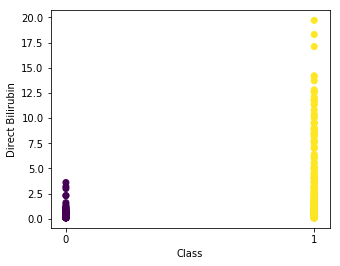

In [13]:
feature1 = df['class'].values
feature2 = df['d_bilirubin'].values 
#feature3 = df[''].values

plt.figure(figsize=(5,4))
plt.xticks(np.arange(min(df['class']), max(df['class'])+1, 1.0))
plt.xlabel('Class')
plt.ylabel('Direct Bilirubin')
plt.scatter(feature1, feature2, c=y) # plot the feature space with color coded classes

### Total Protein VS Class. These features have little to no correlation.

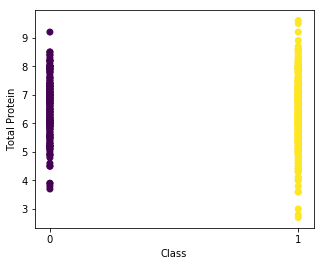

In [14]:
feature1 = df['class'].values
feature2 = df['t_protein'].values 
#feature3 = df2['alb_prop'].values

plt.figure(figsize=(5,4))
plt.xticks(np.arange(min(df['class']), max(df['class'])+1, 1.0))
plt.xlabel('Class')
plt.ylabel('Total Protein')
plt.scatter(feature1, feature2, c=y) # plot the feature space with color coded classes

### Direct Bilirubin (Positive correlation w/ class) & Albumin Proportion (Negative Correlation w/ class) VS Class

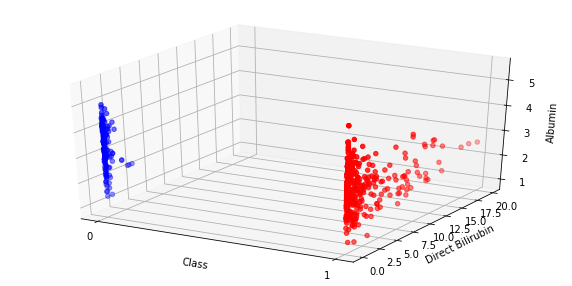

In [15]:
df['class']=df['class'].astype('str')

c = df['class'].values
df['class']=df['class'].astype('int')
c[c=='0'] = 'b' #negative diagnosis of liver disease
c[c=='1'] = 'r' #positive diagnosis of liver disease

feature1 = df['class'].values
feature2 = df['d_bilirubin'].values 
feature3 = df['alb'].values

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, feature3, c=c)
plt.xticks(np.arange(min(df['class']), max(df['class'])+1, 1.0))
ax.set_xlabel('Class')
ax.set_ylabel('Direct Bilirubin')
ax.set_zlabel('Albumin')

plt.show()

### Direct Bilirubin (Positive correlation w/ class) & SGPT (Positive Correlation w/ class) VS Class

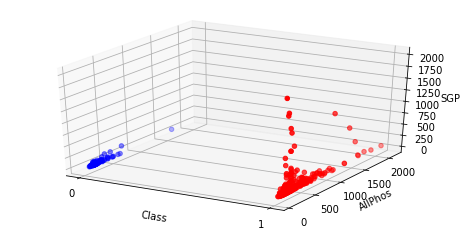

In [16]:
feature1 = df['class'].values
feature2 = df['alkphos'].values 
feature3 = df['sgpt'].values

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, feature3, c=c)
plt.xticks(np.arange(min(df['class']), max(df['class'])+1, 1.0))
ax.set_xlabel('Class')
ax.set_ylabel('AllPhos')
ax.set_zlabel('SGPT')

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013EDC208>,
      dtype=object)

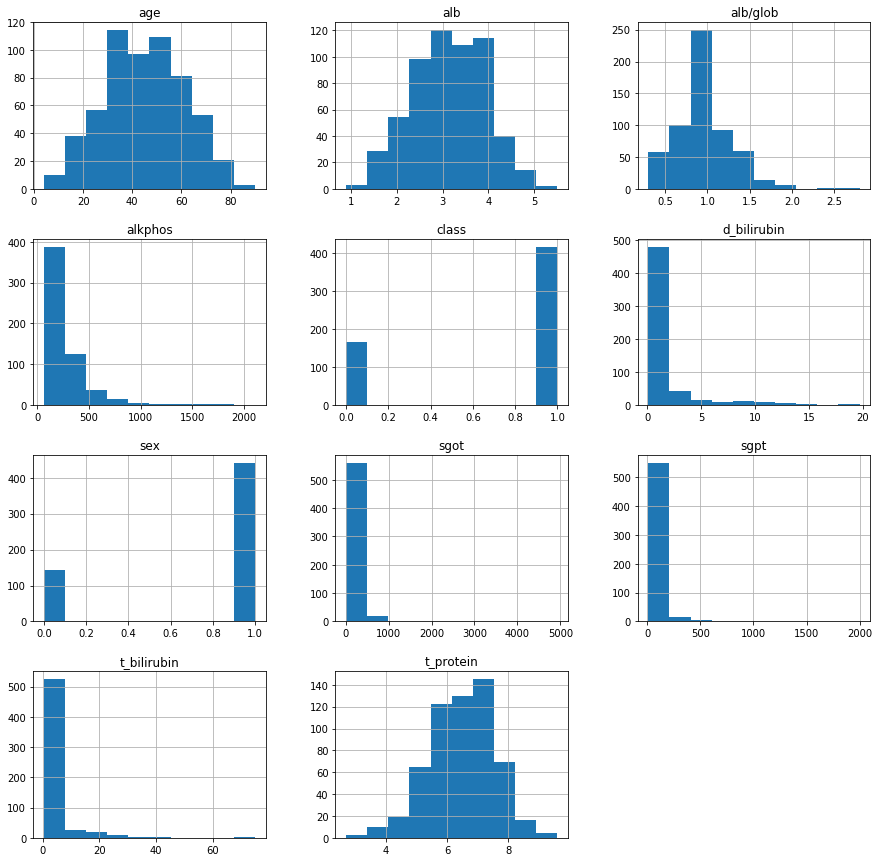

In [17]:
#DataVisualization
df.hist(figsize=(15,15))

For most readings there is a normal distribution, as can be seen above, and as explained before, there are outliers that could be interfering. Features Alkaline Phosphatase, Direct Bilirubin, Total Bilirubin, SGOT and SGPT appear to have a Poisson distribution.

age               AxesSubplot(0.125,0.749828;0.168478x0.130172)
sex            AxesSubplot(0.327174,0.749828;0.168478x0.130172)
t_bilirubin    AxesSubplot(0.529348,0.749828;0.168478x0.130172)
d_bilirubin    AxesSubplot(0.731522,0.749828;0.168478x0.130172)
alkphos           AxesSubplot(0.125,0.593621;0.168478x0.130172)
sgpt           AxesSubplot(0.327174,0.593621;0.168478x0.130172)
sgot           AxesSubplot(0.529348,0.593621;0.168478x0.130172)
t_protein      AxesSubplot(0.731522,0.593621;0.168478x0.130172)
alb               AxesSubplot(0.125,0.437414;0.168478x0.130172)
alb/glob       AxesSubplot(0.327174,0.437414;0.168478x0.130172)
class          AxesSubplot(0.529348,0.437414;0.168478x0.130172)
dtype: object

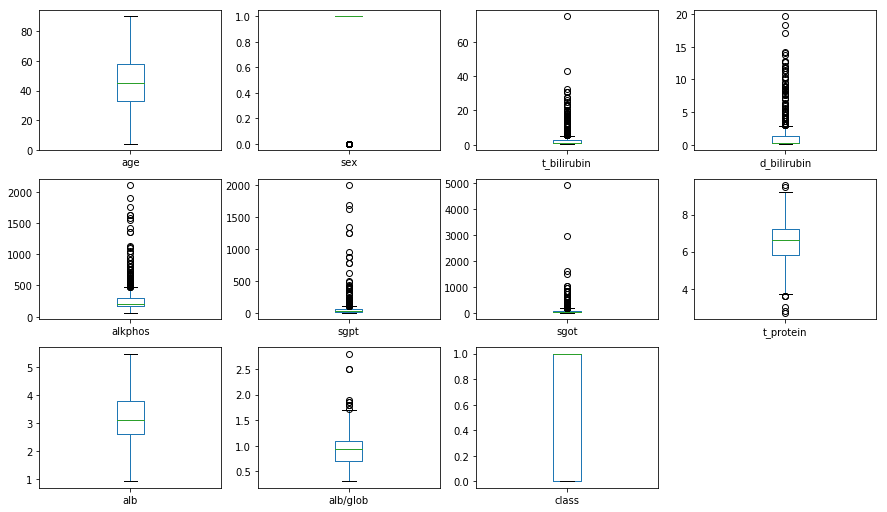

In [18]:
df.plot(kind= 'box' , subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))

The box plots show a better display of the sample distribution in the dataset, since a number of samples fall outside the whiskers of the plot. Some of these outliers are treated in the following section.

### Removing outliers

In [19]:
df2 = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # from stack overflow

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 582
Data columns (total 11 columns):
age            536 non-null int64
sex            536 non-null int64
t_bilirubin    536 non-null float64
d_bilirubin    536 non-null float64
alkphos        536 non-null int64
sgpt           536 non-null int64
sgot           536 non-null int64
t_protein      536 non-null float64
alb            536 non-null float64
alb/glob       536 non-null float64
class          536 non-null int32
dtypes: float64(5), int32(1), int64(5)
memory usage: 48.2 KB


In [20]:
df2.describe()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,class
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,44.686567,0.751866,2.197948,0.987687,257.798507,56.667910,77.492537,6.510448,3.181530,0.950821,0.690299
std,16.288597,0.432334,3.124587,1.677458,146.100402,71.240187,117.883785,1.054905,0.793298,0.293985,0.462802
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,3.600000,0.900000,0.300000,0.000000
25%,33.000000,1.000000,0.800000,0.200000,174.000000,22.000000,24.000000,5.800000,2.600000,0.750000,0.000000
50%,45.000000,1.000000,0.900000,0.300000,204.000000,33.000000,40.000000,6.600000,3.100000,1.000000,1.000000
75%,58.000000,1.000000,2.000000,1.000000,289.250000,56.250000,75.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,19.600000,9.500000,950.000000,622.000000,950.000000,9.600000,5.500000,1.900000,1.000000


# Feature engineering
### Feature creation
It's possible to create new relations from the original features, which could be of importance for a machine learninig model. As seen below, there is no correlation between Class and Total Protein, but proportion of measured proteins could be important for the development of liver disease.

In [21]:
df2.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [22]:
#sve2_all.loc[sve2_all['Hgtot ng/l'] > 100] = np.nan
#sve2_all    [sve2_all['Hgtot ng/l'] > 100] = np.nan

In [23]:
pd.options.mode.chained_assignment = None  # default='warn' . In this case there is no need to worry about SettingWithCopyWarning

df2['ind_bilirubin'] =  df2.apply(lambda row: row.t_bilirubin - row.d_bilirubin, axis=1)

df2['sgpt_prop'] =      df2.apply(lambda row: row.sgpt / row.t_protein, axis=1)
df2['sgot_prop'] =      df2.apply(lambda row: row.sgot / row.t_protein, axis=1)
df2['sgot_sgpt_prop'] = df2.apply(lambda row: (row.sgpt + row.sgot) / row.t_protein, axis=1)

df2['alkphos_prop'] =   df2.apply(lambda row: row.alkphos / row.t_protein, axis=1)

df2['glob'] =           df2.apply(lambda row: row.alb / row["alb/glob"], axis=1)
df2['glob_prop'] =      df2.apply(lambda row: row["glob"] / row.t_protein, axis=1)

df2['alb_prop'] =       df2.apply(lambda row: row.alb / row.t_protein, axis=1)

In [24]:
df2.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,class,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767


In [25]:
# Pushes Class column to the end of the dataframe for easier indexing
col_at_end = ['class']
df2 = df2[[c for c in df2 if c not in col_at_end] 
        + [c for c in col_at_end if c in df2]]
df2.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767,1


In [26]:
df2.describe()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,44.686567,0.751866,2.197948,0.987687,257.798507,56.667910,77.492537,6.510448,3.181530,0.950821,1.210261,8.962803,12.444576,21.407378,40.812098,3.469173,0.537848,0.485179,0.690299
std,16.288597,0.432334,3.124587,1.677458,146.100402,71.240187,117.883785,1.054905,0.793298,0.293985,1.598804,11.993360,20.698879,31.233514,25.263892,0.685520,0.095673,0.075913,0.462802
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,3.600000,0.900000,0.300000,-7.200000,1.447368,1.395349,3.139535,10.862069,1.220930,0.244186,0.235294,0.000000
25%,33.000000,1.000000,0.800000,0.200000,174.000000,22.000000,24.000000,5.800000,2.600000,0.750000,0.600000,3.445582,3.579424,7.500000,26.041733,3.000000,0.482810,0.439848,0.000000
50%,45.000000,1.000000,0.900000,0.300000,204.000000,33.000000,40.000000,6.600000,3.100000,1.000000,0.700000,5.166122,6.138148,11.595455,32.736787,3.416667,0.519109,0.500000,1.000000
75%,58.000000,1.000000,2.000000,1.000000,289.250000,56.250000,75.000000,7.200000,3.800000,1.100000,1.125000,9.433638,11.973214,22.011885,45.217391,4.000000,0.585863,0.535714,1.000000
max,90.000000,1.000000,19.600000,9.500000,950.000000,622.000000,950.000000,9.600000,5.500000,1.900000,10.100000,141.388889,237.500000,314.444444,194.680851,6.000000,1.071429,0.750000,1.000000


In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 582
Data columns (total 19 columns):
age               536 non-null int64
sex               536 non-null int64
t_bilirubin       536 non-null float64
d_bilirubin       536 non-null float64
alkphos           536 non-null int64
sgpt              536 non-null int64
sgot              536 non-null int64
t_protein         536 non-null float64
alb               536 non-null float64
alb/glob          536 non-null float64
ind_bilirubin     536 non-null float64
sgpt_prop         536 non-null float64
sgot_prop         536 non-null float64
sgot_sgpt_prop    536 non-null float64
alkphos_prop      536 non-null float64
glob              536 non-null float64
glob_prop         536 non-null float64
alb_prop          536 non-null float64
class             536 non-null int32
dtypes: float64(13), int32(1), int64(5)
memory usage: 81.7 KB


In [28]:
# transfer new data into new X and y arrays

X = np.array(df2.iloc[:, :-1].values)
y = np.array(df2.iloc[:, -1].values) # class label is contained here

np.mean(y), np.std(y), np.var(y)  

(0.6902985074626866, 0.46237049868852337, 0.2137864780574738)

### Data split into training and test sets

In [29]:
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.15, random_state=1)

### Oversampling the minority class of the training set with SMOTE

In [30]:
print('Original dataset shape %s' % Counter(y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
X_res, y_res = smote.fit_resample(X_train, y_train)
              
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 314, 0: 141})
Resampled dataset shape Counter({1: 314, 0: 314})


### Data scaling. First on training data, and using that information to scale the test data.

In [31]:
stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_res)
X_test = stdsc.transform(X_test)

In [32]:
y_train = y_res

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(628, 18)
(628,)
(81, 18)
(81,)


In [34]:
# Saving preprocessed data to files for transfer to UCL servers
np.save('X_train', X_train) # save the file 
np.save('y_train', y_train) # save the file as "outfile_name.npy" 
np.save('X_test', X_test) # save the file as "outfile_name.npy"
np.save('y_test', y_test) # save the file as "outfile_name.npy" 

# Support Vector Machine Classification

The SVM is a binary classification algorithm where input vectors are non-linearly mapped to a high dimension feature space where a linear decision surface (plane, or hyperplane in higher dimensions) is constructed, which properties ensures the high generalization ability of the algorithm at the time of separating the two classes (7), the support vectors being the data points that lie closest to said surface and the most difficult to classify. Ideally, new data points to be classified would fall between these support vectors and the bulk of the training data. 

## Sequential feature selection

In [35]:
class SBS(): # from practical lectures at UCL
    def __init__(self, estimator, k_features, scoring=roc_auc_score,
                 test_size=0.15, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
X_train.shape[1]    

18

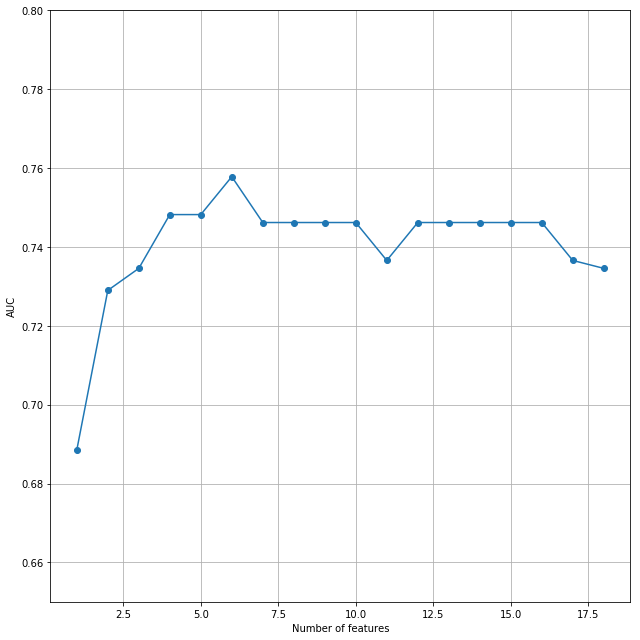

In [36]:
svc = SVC(gamma = 'auto', random_state=1)

# selecting features
sbs = SBS(svc, k_features=1)
sbs.fit(X_train, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.rcParams['figure.figsize']=(9,9)
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.65, 0.8])
plt.ylabel('AUC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [37]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17),
 (0, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17),
 (0, 2, 3, 5, 6, 7, 9, 11, 12, 13, 14, 16, 17),
 (0, 2, 3, 5, 6, 7, 9, 12, 13, 14, 16, 17),
 (0, 2, 3, 5, 6, 7, 9, 12, 13, 16, 17),
 (0, 2, 5, 6, 7, 9, 12, 13, 16, 17),
 (0, 2, 5, 6, 7, 9, 12, 13, 17),
 (0, 2, 5, 6, 7, 9, 12, 17),
 (0, 2, 5, 6, 9, 12, 17),
 (0, 5, 6, 9, 12, 17),
 (0, 5, 9, 12, 17),
 (0, 9, 12, 17),
 (0, 9, 12),
 (0, 12),
 (12,)]

In [38]:
k6=list(sbs.subsets_[-6])
print(k6)

feature_labels = df2.columns[0:-1]
print (feature_labels[k6])

[0, 5, 6, 9, 12, 17]
Index(['age', 'sgpt', 'sgot', 'alb/glob', 'sgot_prop', 'alb_prop'], dtype='object')


In [39]:
features_selected = ['age', 'sgpt', 'sgot', 'alb/glob', 'sgot_prop', 'alb_prop', 'class']
df_fsel = df2.loc[:, features_selected]
df_fsel.head()

,age,sgpt,sgot,alb/glob,sgot_prop,alb_prop,class
0,65,16,18,0.90,2.647059,0.485294,1
1,62,64,100,0.74,13.333333,0.426667,1
2,62,60,68,0.89,9.714286,0.471429,1
3,58,14,20,1.00,2.941176,0.500000,1
4,72,27,59,0.40,8.082192,0.328767,1


In [40]:
df_fsel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 582
Data columns (total 7 columns):
age          536 non-null int64
sgpt         536 non-null int64
sgot         536 non-null int64
alb/glob     536 non-null float64
sgot_prop    536 non-null float64
alb_prop     536 non-null float64
class        536 non-null int32
dtypes: float64(3), int32(1), int64(3)
memory usage: 31.4 KB


Two of the created features are relevant for a SVM classifier, "Albumin Proportion" and "SGOT proportion".

### Redefining X and y after feature selection

In [41]:
X = np.array(df_fsel.iloc[:, :-1].values)
y = np.array(df_fsel.iloc[:, -1].values) # class label is contained here

In [42]:
X

array([[ 65.        ,  16.        ,  18.        ,   0.9       ,
          2.64705882,   0.48529412],
       [ 62.        ,  64.        , 100.        ,   0.74      ,
         13.33333333,   0.42666667],
       [ 62.        ,  60.        ,  68.        ,   0.89      ,
          9.71428571,   0.47142857],
       ...,
       [ 52.        ,  48.        ,  49.        ,   1.        ,
          7.65625   ,   0.5       ],
       [ 31.        ,  29.        ,  32.        ,   1.        ,
          4.70588235,   0.5       ],
       [ 38.        ,  21.        ,  24.        ,   1.5       ,
          3.28767123,   0.60273973]])

In [43]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,

In [44]:
svmX_train, svmX_test, svmy_train, svmy_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [45]:
print('Original dataset shape %s' % Counter(svmy_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
svmX_res, svmy_res = smote.fit_resample(svmX_train, svmy_train)

print('Resampled dataset shape %s' % Counter(svmy_res))

Original dataset shape Counter({1: 314, 0: 141})
Resampled dataset shape Counter({1: 314, 0: 314})


In [46]:
stdsc = StandardScaler()

svmX_train = stdsc.fit_transform(svmX_res)
svmX_test = stdsc.transform(svmX_test)

svmy_train = svmy_res

In [47]:
print(svmX_train.shape)
print(svmy_train.shape)
print(svmX_test.shape)
print(svmy_test.shape)

(628, 6)
(628,)
(81, 6)
(81,)


### Data has been scaled with the most relevant features

In [48]:
# Saving preprocessed data to files for transfer to UCL servers
np.save('svmX_train', svmX_train) 
np.save('svmy_train', svmy_train) 
np.save('svmX_test', svmX_test) 
np.save('svmy_test', svmy_test) 

### Base SVM

In [49]:
base_svm = svm.SVC(probability = True, random_state=1)
base_svm.fit(svmX_train, svmy_train)  

base_training_prediction = base_svm.predict(svmX_train)

base_prediction = base_svm.predict(svmX_test)


In [50]:
base_svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False)

In [51]:
plt.rcParams['figure.figsize']=(7,7)

def training_metrics(clf, X_train, y_train, prediction):
    
    # training metrics
    print("Evaluation parameters on training data:")
    print("\n")

    print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, prediction)))
    print("AUC: {0:.4f}".format(metrics.roc_auc_score(y_train, prediction)))
    print("Precision: {0:.4f}".format(metrics.precision_score(y_train, prediction)))
    print("Recall: {0:.4f}".format(metrics.recall_score(y_train, prediction)))
    print("F1: {0:.4f}".format(metrics.f1_score(y_train, prediction)))

    print("\n")
    print("Confusion Matrix")
    print(confusion_matrix(y_train, prediction))

    tr_probas = clf.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, tr_probas[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    current_auc = str('%.2f' %roc_auc)
    fig = plt.figure(figsize=(5, 5))    
    plt.plot(fpr, tpr, lw=1, label= str('Classifier on training data' + ' AUC: ' + current_auc))

    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             color=(0.6, 0.6, 0.6), 
             label='random guessing')

    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2, 
             linestyle=':', 
             color='black', 
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    

Evaluation parameters on training data:


Accuracy: 0.7134
AUC: 0.7134
Precision: 0.8384
Recall: 0.5287
F1: 0.6484


Confusion Matrix
[[282  32]
 [148 166]]


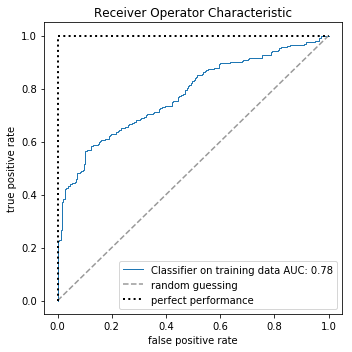

In [52]:
training_metrics(base_svm, svmX_train, svmy_train, base_training_prediction)

In [53]:
tn, fp, fn, tp = confusion_matrix(svmy_train, base_training_prediction).ravel()
(tn, fp, fn, tp)


(282, 32, 148, 166)

In [54]:
def testing_metrics(clf, X_test, y_test, prediction):
    
    # training metrics
    print("Evaluation parameters on testing data:")
    print("\n")

    print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, prediction)))
    print("AUC: {0:.4f}".format(metrics.roc_auc_score(y_test, prediction)))
    print("Precision: {0:.4f}".format(metrics.precision_score(y_test, prediction)))
    print("Recall: {0:.4f}".format(metrics.recall_score(y_test, prediction)))
    print("F1: {0:.4f}".format(metrics.f1_score(y_test, prediction)))

    print("\n")
    print("Confusion Matrix")
    print(confusion_matrix(y_test, prediction))

    tr_probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, tr_probas[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    current_auc = str('%.2f' %roc_auc)
    fig = plt.figure(figsize=(5, 5))    
    plt.plot(fpr, tpr, lw=1, label= str('Classifier on testing data' + ' AUC: ' + current_auc))

    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             color=(0.6, 0.6, 0.6), 
             label='random guessing')

    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2, 
             linestyle=':', 
             color='black', 
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

Evaluation parameters on testing data:


Accuracy: 0.5556
AUC: 0.6121
Precision: 0.8125
Recall: 0.4643
F1: 0.5909


Confusion Matrix
[[19  6]
 [30 26]]


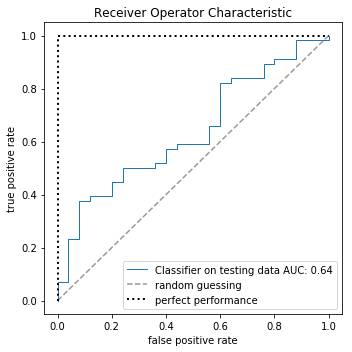

In [55]:
testing_metrics(base_svm, svmX_test, svmy_test, base_prediction)

In [108]:
tn, fp, fn, tp = confusion_matrix(svmy_test, base_prediction).ravel()
(tn, fp, fn, tp)


(19, 6, 30, 26)

# SVM Hyperparameters tunning with GridSearchCV

In [60]:
# CAUTION: POLYNOMIAL KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE

# GridSearch for rbf, linear and sigmoid kernels after feature selection with AUC as scoring
num_folds = 10

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   

tuned_parameters = [{'kernel': ['rbf'],    'gamma': param_range, 'C': param_range, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'], 'random_state': [1]},
                    {'kernel': ['rbf'],     'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['linear'],  'gamma': param_range, 'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['linear'],   'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['sigmoid'], 'gamma': param_range, 'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'coef0': param_range, 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['sigmoid'],  'C': param_range, 'random_state': [1], 'shrinking' : [True, False],'coef0': param_range, 'decision_function_shape':['ovo', 'ovr']}]              
                   #{'kernel': ['poly'], 'gamma': [0.001, 0.01, 0.1, 1.0, 2.0, 3.0], 'C': param_range}  #TAKES TOO MUCH TIME!!!! HOURS!
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            
                      cv=num_folds,
                      n_jobs=3)

gs_svc = gs_svc.fit(svmX_train, svmy_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.7736927265255804
--> Best Parameters: 
 {'C': 1.0, 'decision_function_shape': 'ovo', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [73]:
best_svm1 = SVC(C =1,
               gamma = 10,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

Evaluation parameters on testing data:


Accuracy: 0.6296
AUC: 0.5993
Precision: 0.7600
Recall: 0.6786
F1: 0.7170


Confusion Matrix
[[13 12]
 [18 38]]


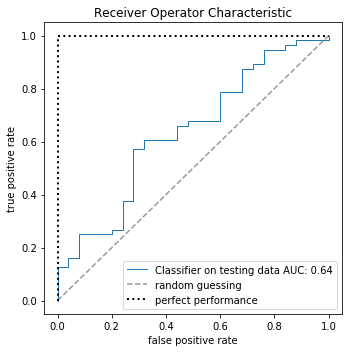

In [74]:
best_svm1.fit(svmX_train, svmy_train)  

best_svm_prediction1 = best_svm1.predict(svmX_test)

testing_metrics(best_svm1, svmX_test, svmy_test, best_svm_prediction1)

In [65]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE
# GridSearch for rbf kernel after feature selection with AUC as scoring
num_folds = 10

#param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   
narrow_range = [0.7,0.8,0.9, 1,1.5,2,2.5,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

tuned_parameters = [{'kernel': ['rbf'],    'gamma': narrow_range, 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']},
                   {'kernel': ['rbf'],    'gamma': ['auto'], 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']}]
                   #{'kernel': ['linear'],  'gamma': param_range, 'C': param_range, 'random_state': [1]},
                   #{'kernel': ['sigmoid'], 'gamma': param_range, 'C': param_range, 'random_state': [1], 'coef0': param_range}]              
                   #{'kernel': ['poly'], 'gamma': [0.001, 0.01, 0.1, 1.0, 2.0, 3.0], 'C': param_range}  #TAKES TOO MUCH TIME!!!! HOURS!
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            
                      cv=num_folds,
                      n_jobs=3)

gs_svc = gs_svc.fit(X_train, y_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.8894146805013354
--> Best Parameters: 
 {'C': 2.5, 'decision_function_shape': 'ovo', 'gamma': 2, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [75]:
best_svm2 = SVC(C =2.5,
               gamma = 2,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

Evaluation parameters on testing data:


Accuracy: 0.6420
AUC: 0.6636
Precision: 0.8293
Recall: 0.6071
F1: 0.7010


Confusion Matrix
[[18  7]
 [22 34]]


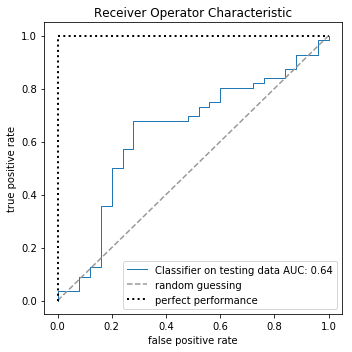

In [76]:
best_svm2.fit(svmX_train, svmy_train)  

best_svm_prediction2 = best_svm2.predict(svmX_test)

testing_metrics(best_svm2, svmX_test, svmy_test, best_svm_prediction2)

In [71]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE
# GridSearch for rbf and linear kernels after feature selection with AUC as scoring
num_folds = 10

narrow_range = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,2,2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': narrow_range, 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['rbf'], 'gamma': ['auto'],     'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']}]
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            # for assignment use AUC or F1 score
                      cv=num_folds,
                      n_jobs=3)

gs_svc = gs_svc.fit(X_train, y_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.8907437846722827
--> Best Parameters: 
 {'C': 1.9, 'decision_function_shape': 'ovo', 'gamma': 2.3, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [77]:
best_svm3 = SVC(C =1.9,
               gamma = 2.3,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

### Best SVM hyperparameters

Evaluation parameters on testing data:


Accuracy: 0.6420
AUC: 0.6636
Precision: 0.8293
Recall: 0.6071
F1: 0.7010


Confusion Matrix
[[18  7]
 [22 34]]


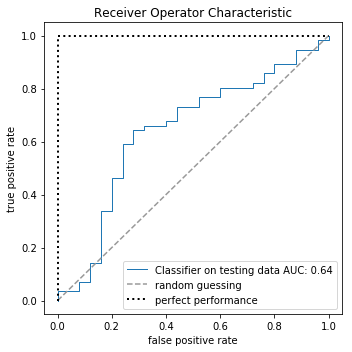

In [78]:
best_svm3.fit(svmX_train, svmy_train)  

best_svm_prediction3 = best_svm3.predict(svmX_test)

testing_metrics(best_svm3, svmX_test, svmy_test, best_svm_prediction3)

In [105]:
tn, fp, fn, tp = confusion_matrix(svmy_test, best_svm_prediction3).ravel()
(tn, fp, fn, tp)


(18, 7, 22, 34)

In [109]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE

num_folds = 10

#param_range = [0.01, 0.1, 1, 10]#, 1.0, 10.0, 100.0, 1000.0]   
narrow_range = [0.001, 0.01, 0.1, 1,2,3,4]#, 5, 6, 7, 8, 9, 10, 20, 30, 40]

tuned_parameters = [{'kernel': ['poly'], 'gamma': narrow_range, 'C': narrow_range, 'degree' : narrow_range}]
                                      
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            # for assignment use AUC or F1 score
                      cv=num_folds,
                      n_jobs=3)

gs_svc = gs_svc.fit(X_train, y_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.7856129289089788
--> Best Parameters: 
 {'C': 2, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}


In [79]:
poly_svm = SVC(C=2,
              degree=3,
              gamma=1,
              kernel='poly',
               probability=True,
              random_state=1)

Evaluation parameters on testing data:


Accuracy: 0.4938
AUC: 0.5896
Precision: 0.8261
Recall: 0.3393
F1: 0.4810


Confusion Matrix
[[21  4]
 [37 19]]


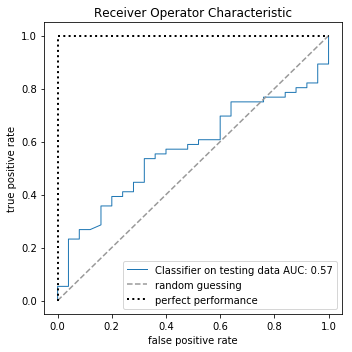

In [80]:
poly_svm.fit(svmX_train, svmy_train)  

poly_svm_prediction = poly_svm.predict(svmX_test)

testing_metrics(poly_svm, svmX_test, svmy_test, poly_svm_prediction)

## Sensitivity Analysis

Evaluation parameters on testing data:


Accuracy: 0.6173
AUC: 0.5350
Precision: 0.7119
Recall: 0.7500
F1: 0.7304


Confusion Matrix
[[ 8 17]
 [14 42]]


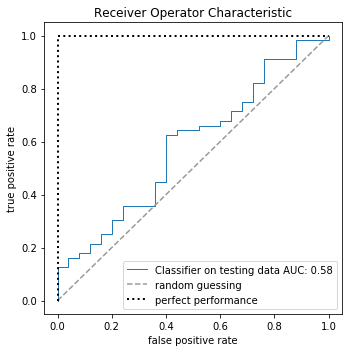

In [81]:
sens_svm = SVC(C =1.9,
               gamma = 20,                      # changing gamma from 2.3 to 20
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

sens_svm.fit(svmX_train, svmy_train)
sens_svm_prediction = sens_svm.predict(svmX_test)
                                       
testing_metrics(sens_svm, svmX_test, svmy_test, sens_svm_prediction)

Evaluation parameters on testing data:


Accuracy: 0.5802
AUC: 0.5525
Precision: 0.7292
Recall: 0.6250
F1: 0.6731


Confusion Matrix
[[12 13]
 [21 35]]


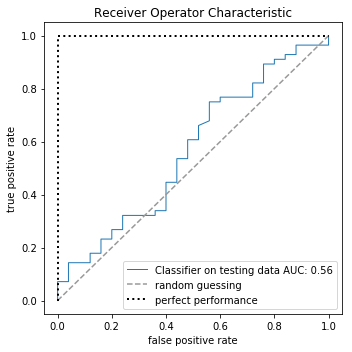

In [82]:
sens_svm = SVC(C =20,                           # changing C from 1.9 to 20
               gamma = 2.3,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

sens_svm.fit(svmX_train, svmy_train)
sens_svm_prediction = sens_svm.predict(svmX_test)
                                       
testing_metrics(sens_svm, svmX_test, svmy_test, sens_svm_prediction)

Modifying the C and gamma parameters to a higher order of magnitude shows how sensible the SVM algorithm is to its changing values. Although the Recall criteria improved with the higher values, every other criteria tracked showed lower scores. If the Recall criteria is taken as the primary evaluation parameter, paying attention to False negatives, it could be argued that an optimized SVM for ROC-AUC is not ideal method, and maximizing Recall would be a better optimization instead of the former. These results of the suggests that the SVM is more sensible to changes in orders of magnitude of its C parameter than the gamma value. 

# SVM considering outliers

In [56]:
pd.options.mode.chained_assignment = None  # default='warn' . In this case there is no need to worry about SettingWithCopyWarning

df['ind_bilirubin']  = df.apply(lambda row: row.t_bilirubin - row.d_bilirubin, axis=1)
df['sgpt_prop']      = df.apply(lambda row: row.sgpt / row.t_protein, axis=1)
df['sgot_prop']      = df.apply(lambda row: row.sgot / row.t_protein, axis=1)
df['sgot_sgpt_prop'] = df.apply(lambda row: (row.sgpt + row.sgot) / row.t_protein, axis=1)
df['alkphos_prop']   = df.apply(lambda row: row.alkphos / row.t_protein, axis=1)
df['glob']           = df.apply(lambda row: row.alb / row["alb/glob"], axis=1)
df['glob_prop']      = df.apply(lambda row: row["glob"] / row.t_protein, axis=1)
df['alb_prop']       = df.apply(lambda row: row.alb / row.t_protein, axis=1)

In [57]:
df.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,class,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767


In [58]:
# Pushes Class column to the end of the dataframe for easier indexing
col_at_end = ['class']
df = df[[c for c in df if c not in col_at_end] 
        + [c for c in col_at_end if c in df]]
df.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767,1


In [59]:
# transfer new data into new X and y arrays

X = np.array(df.iloc[:, :-1].values)
y = np.array(df.iloc[:, -1].values) # class label is contained here

np.mean(y), np.std(y), np.var(y)  

(0.7135506003430532, 0.45210191449840326, 0.20439614109312151)

### Data split into training and test sets

In [60]:
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.15, random_state=1)

### Oversampling the minority class of the training set with SMOTE

In [61]:
print('Original dataset shape %s' % Counter(y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
X_res, y_res = smote.fit_resample(X_train, y_train)
              
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 349, 0: 146})
Resampled dataset shape Counter({1: 349, 0: 349})


### Data scaling. First on training data, and using that information to scale the test data.

In [62]:
stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_res)
X_test = stdsc.transform(X_test)

In [63]:
y_train = y_res

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(698, 18)
(698,)
(88, 18)
(88,)


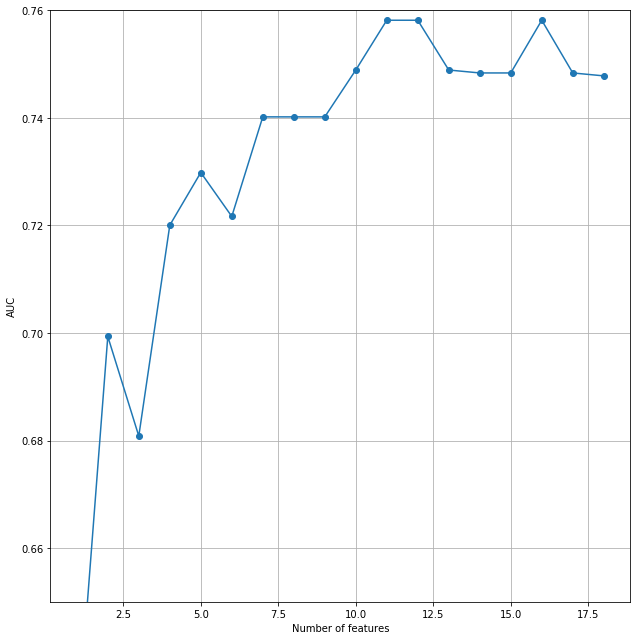

In [97]:
svc = SVC(gamma = 'auto', random_state=1)

# selecting features
sbs = SBS(svc, k_features=1)
sbs.fit(X_train, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.rcParams['figure.figsize']=(9,9)
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.65, 0.76])
plt.ylabel('AUC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [98]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17),
 (0, 1, 2, 3, 5, 7, 8, 9, 10, 13, 14, 16, 17),
 (0, 1, 2, 3, 5, 8, 9, 10, 13, 14, 16, 17),
 (0, 1, 2, 3, 5, 8, 10, 13, 14, 16, 17),
 (0, 1, 2, 3, 5, 8, 10, 14, 16, 17),
 (1, 2, 3, 5, 8, 10, 14, 16, 17),
 (1, 2, 3, 5, 8, 14, 16, 17),
 (1, 3, 5, 8, 14, 16, 17),
 (1, 3, 8, 14, 16, 17),
 (1, 3, 14, 16, 17),
 (1, 3, 14, 16),
 (1, 3, 14),
 (3, 14),
 (14,)]

In [99]:
k11=list(sbs.subsets_[-11])
print(k11)

feature_labels = df.columns[0:-1]
print(feature_labels[k11])

[0, 1, 2, 3, 5, 8, 10, 13, 14, 16, 17]
Index(['age', 'sex', 't_bilirubin', 'd_bilirubin', 'sgpt', 'alb',
       'ind_bilirubin', 'sgot_sgpt_prop', 'alkphos_prop', 'glob_prop',
       'alb_prop'],
      dtype='object')


In [100]:
features_selected = ['age', 'sex', 't_bilirubin', 'd_bilirubin', 'sgpt', 'alb', 
                     'ind_bilirubin', 'sgot_sgpt_prop', 'alkphos_prop', 'glob_prop',
                     'alb_prop', 'class']
df_fsel = df.loc[:, features_selected]
df_fsel.head()

,age,sex,t_bilirubin,d_bilirubin,sgpt,alb,ind_bilirubin,sgot_sgpt_prop,alkphos_prop,glob_prop,alb_prop,class
0,65,0,0.7,0.1,16,3.3,0.6,5.000000,27.500000,0.539216,0.485294,1
1,62,1,10.9,5.5,64,3.2,5.4,21.866667,93.200000,0.576577,0.426667,1
2,62,1,7.3,4.1,60,3.3,3.2,18.285714,70.000000,0.529695,0.471429,1
3,58,1,1.0,0.4,14,3.4,0.6,5.000000,26.764706,0.500000,0.500000,1
4,72,1,3.9,2.0,27,2.4,1.9,11.780822,26.712329,0.821918,0.328767,1


In [101]:
df_fsel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 12 columns):
age               583 non-null int64
sex               583 non-null int64
t_bilirubin       583 non-null float64
d_bilirubin       583 non-null float64
sgpt              583 non-null int64
alb               583 non-null float64
ind_bilirubin     583 non-null float64
sgot_sgpt_prop    583 non-null float64
alkphos_prop      583 non-null float64
glob_prop         583 non-null float64
alb_prop          583 non-null float64
class             583 non-null int32
dtypes: float64(8), int32(1), int64(3)
memory usage: 52.5 KB


### Redefining X and y after feature selection

In [102]:
X = np.array(df_fsel.iloc[:, :-1].values)
y = np.array(df_fsel.iloc[:, -1].values) # class label is contained here

In [103]:
svmX_train, svmX_test, svmy_train, svmy_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [104]:
print('Original dataset shape %s' % Counter(svmy_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
svmX_res, svmy_res = smote.fit_resample(svmX_train, svmy_train)

print('Resampled dataset shape %s' % Counter(svmy_res))

Original dataset shape Counter({1: 349, 0: 146})
Resampled dataset shape Counter({1: 349, 0: 349})


In [105]:
stdsc = StandardScaler()

svmX_train = stdsc.fit_transform(svmX_res)
svmX_test = stdsc.transform(svmX_test)

svmy_train = svmy_res

In [106]:
print(svmX_train.shape)
print(svmy_train.shape)
print(svmX_test.shape)
print(svmy_test.shape)

(698, 11)
(698,)
(88, 11)
(88,)


### Data has been scaled with the most relevant features

### Base SVM

In [107]:
base_svm = svm.SVC(probability = True, random_state=1)
base_svm.fit(svmX_train, svmy_train)  

base_training_prediction = base_svm.predict(svmX_train)

base_prediction = base_svm.predict(svmX_test)


In [108]:
base_svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False)

Evaluation parameters on training data:


Accuracy: 0.7622
AUC: 0.7622
Precision: 0.8894
Recall: 0.5989
F1: 0.7158


Confusion Matrix
[[323  26]
 [140 209]]


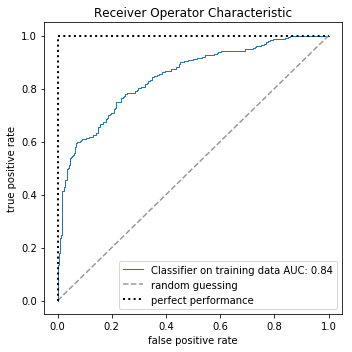

In [109]:
training_metrics(base_svm, svmX_train, svmy_train, base_training_prediction)

Evaluation parameters on testing data:


Accuracy: 0.6477
AUC: 0.7196
Precision: 0.9286
Recall: 0.5821
F1: 0.7156


Confusion Matrix
[[18  3]
 [28 39]]


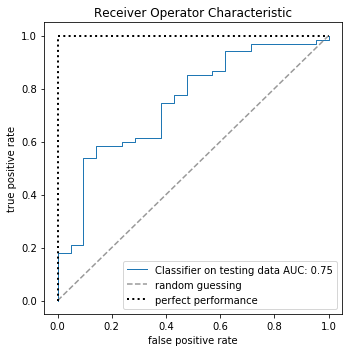

In [110]:
testing_metrics(base_svm, svmX_test, svmy_test, base_prediction)

# SVM Hyperparameters tunning with GridSearchCV

In [111]:
# CAUTION: POLYNOMIAL KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE

# GridSearch for rbf, linear and sigmoid kernels after feature selection with AUC as scoring
num_folds = 10

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   

tuned_parameters = [{'kernel': ['rbf'],    'gamma': param_range, 'C': param_range, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'], 'random_state': [1]},
                    {'kernel': ['rbf'],     'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['linear'],  'gamma': param_range, 'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['linear'],   'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['sigmoid'], 'gamma': param_range, 'C': param_range, 'shrinking' : [True, False],'random_state': [1], 'coef0': param_range, 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['sigmoid'],  'C': param_range, 'random_state': [1], 'shrinking' : [True, False],'coef0': param_range, 'decision_function_shape':['ovo', 'ovr']}]              
                   #{'kernel': ['poly'], 'gamma': [0.001, 0.01, 0.1, 1.0, 2.0, 3.0], 'C': param_range}  #TAKES TOO MUCH TIME!!!! HOURS!
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            
                      cv=num_folds,
                      n_jobs=2)

gs_svc = gs_svc.fit(svmX_train, svmy_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.8808841588211216
--> Best Parameters: 
 {'C': 10.0, 'decision_function_shape': 'ovo', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [112]:
best_svm = SVC(C =10,
               gamma = 10,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

Evaluation parameters on testing data:


Accuracy: 0.7386
AUC: 0.5341
Precision: 0.7750
Recall: 0.9254
F1: 0.8435


Confusion Matrix
[[ 3 18]
 [ 5 62]]


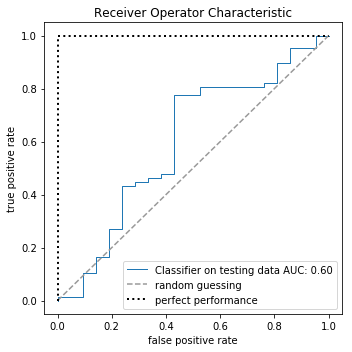

In [113]:
best_svm.fit(svmX_train, svmy_train)  

best_svm_prediction = best_svm.predict(svmX_test)

testing_metrics(best_svm, svmX_test, svmy_test, best_svm_prediction)

In [117]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE
# GridSearch for rbf kernel after feature selection with AUC as scoring
num_folds = 10

#param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   
narrow_range = [0.7,0.8,0.9, 1,1.5,2,2.5,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

tuned_parameters = [{'kernel': ['rbf'],    'gamma': narrow_range, 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']},
                   {'kernel': ['rbf'],    'gamma': ['auto'], 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']}]
                   #{'kernel': ['linear'],  'gamma': param_range, 'C': param_range, 'random_state': [1]},
                   #{'kernel': ['sigmoid'], 'gamma': param_range, 'C': param_range, 'random_state': [1], 'coef0': param_range}]              
                   #{'kernel': ['poly'], 'gamma': [0.001, 0.01, 0.1, 1.0, 2.0, 3.0], 'C': param_range}  #TAKES TOO MUCH TIME!!!! HOURS!
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            
                      cv=num_folds,
                      n_jobs=3)

gs_svc = gs_svc.fit(svmX_train, svmy_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.8900724759817967
--> Best Parameters: 
 {'C': 8, 'decision_function_shape': 'ovo', 'gamma': 6, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [118]:
best_svm = SVC(C =8,
               gamma = 6,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

Evaluation parameters on testing data:


Accuracy: 0.6818
AUC: 0.5131
Precision: 0.7671
Recall: 0.8358
F1: 0.8000


Confusion Matrix
[[ 4 17]
 [11 56]]


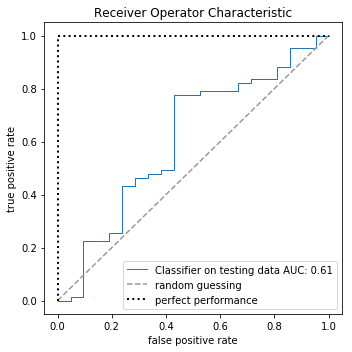

In [119]:
best_svm.fit(svmX_train, svmy_train)  

best_svm_prediction = best_svm.predict(svmX_test)

testing_metrics(best_svm, svmX_test, svmy_test, best_svm_prediction)

In [120]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE
# GridSearch for rbf and linear kernels after feature selection with AUC as scoring
num_folds = 10

narrow_range = [4,5,6,7,8,9,10]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': narrow_range, 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['rbf'], 'gamma': ['auto'],     'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']}]
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            # for assignment use AUC or F1 score
                      cv=num_folds,
                      n_jobs=-1)

gs_svc = gs_svc.fit(svmX_train, svmy_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.8900724759817967
--> Best Parameters: 
 {'C': 8, 'decision_function_shape': 'ovo', 'gamma': 6, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [121]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE
# GridSearch for rbf and linear kernels after feature selection with AUC as scoring
num_folds = 10

narrow_range = [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5 ,10]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': narrow_range, 'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']},
                    {'kernel': ['rbf'], 'gamma': ['auto'],     'C': narrow_range, 'random_state': [1],'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr']}]
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            # for assignment use AUC or F1 score
                      cv=num_folds,
                      n_jobs=-1)

gs_svc = gs_svc.fit(svmX_train, svmy_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.890313259974477
--> Best Parameters: 
 {'C': 9.5, 'decision_function_shape': 'ovo', 'gamma': 5.5, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [122]:
best_svm = SVC(C =9.5,
               gamma = 5.5,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

Evaluation parameters on testing data:


Accuracy: 0.6932
AUC: 0.5370
Precision: 0.7778
Recall: 0.8358
F1: 0.8058


Confusion Matrix
[[ 5 16]
 [11 56]]


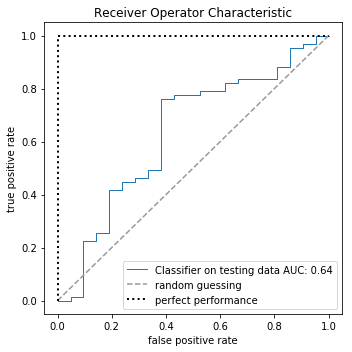

In [123]:
best_svm.fit(svmX_train, svmy_train)  

best_svm_prediction = best_svm.predict(svmX_test)

testing_metrics(best_svm, svmX_test, svmy_test, best_svm_prediction)

In [125]:
# CAUTION: POLY KERNEL FOR SVM TAKES A LONG TIME TO PROCESS. HOURS.
# Probability : FALSE
# GridSearch for rbf and linear kernels after feature selection with AUC as scoring
num_folds = 10

narrow_range = [5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 9.1, 9.2, 9.3, 9.4, 9.5 , 9.6, 9.7, 9.8, 9.9, 10]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': narrow_range, 'C': narrow_range, 'random_state': [1],'shrinking' : [True], 'decision_function_shape':['ovo']},
                    {'kernel': ['rbf'], 'gamma': ['auto'],     'C': narrow_range, 'random_state': [1],'shrinking' : [True], 'decision_function_shape':['ovo']}]
                   
gs_svc = GridSearchCV(estimator= SVC(),
                      param_grid=tuned_parameters,
                      scoring='roc_auc',            # for assignment use AUC or F1 score
                      cv=num_folds,
                      n_jobs=-2)

gs_svc = gs_svc.fit(svmX_train, svmy_train)
print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
print('--> Best Parameters: \n',gs_svc.best_params_)

--> Tuned Parameters Best Score:  0.8907225927620331
--> Best Parameters: 
 {'C': 9.5, 'decision_function_shape': 'ovo', 'gamma': 5.4, 'kernel': 'rbf', 'random_state': 1, 'shrinking': True}


In [126]:
best_svm = SVC(C =9.5,
               gamma = 5.4,
               decision_function_shape = 'ovo',
               shrinking = True,
               kernel = 'rbf',
               probability = True,
               random_state = 1)

Evaluation parameters on testing data:


Accuracy: 0.6932
AUC: 0.5370
Precision: 0.7778
Recall: 0.8358
F1: 0.8058


Confusion Matrix
[[ 5 16]
 [11 56]]


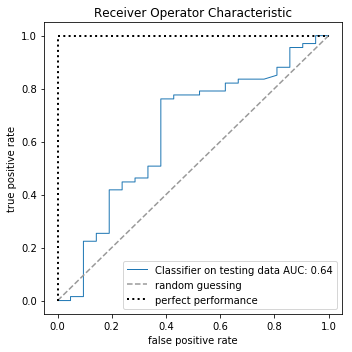

In [127]:
best_svm.fit(svmX_train, svmy_train)  

best_svm_prediction = best_svm.predict(svmX_test)

testing_metrics(best_svm, svmX_test, svmy_test, best_svm_prediction)

### Is it better with or without outliers?

The inclusion of the outlier data influences the generalisation capabilities of the SVM. 
* Accuracy improves from 0.64 to 0.69.
* Precision deteriorates from 0.83 to 0.78.
* Recall improves from 0.61 to 0.84.
* F1-score improves from 0.70 to 0.81.
* AUC score based on data deteriorates from 0.66 to 0.54, but based on probablities (graph) stays at 0.64.

In general, it seems that these outlier data points are important for a SVM classification algorithm and shouldn't be discarded.

# Random forest

The RF classification algorithm is an ensemble of a given number of Decision Trees, such that each tree depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest. (8). This results in a greater tree diversity, which trades a higher bias for a lower variance and generally gives better results than any individual Decision Tree. The randomness in building each tree of the RF forces the algorithm to consider many possible explanations, the result being that the RF captures a much broader picture of the data than a single tree, avoiding over fitting to the data and achieving a good generalization.

## Feature Selection

In [128]:
df2.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767,1


In [129]:
X = np.array(df2.iloc[:, :-1].values)
y = np.array(df2.iloc[:, -1].values) # class label is contained here

In [130]:
X

array([[65.        ,  0.        ,  0.7       , ...,  3.66666667,
         0.53921569,  0.48529412],
       [62.        ,  1.        , 10.9       , ...,  4.32432432,
         0.57657658,  0.42666667],
       [62.        ,  1.        ,  7.3       , ...,  3.70786517,
         0.52969502,  0.47142857],
       ...,
       [52.        ,  1.        ,  0.8       , ...,  3.2       ,
         0.5       ,  0.5       ],
       [31.        ,  1.        ,  1.3       , ...,  3.4       ,
         0.5       ,  0.5       ],
       [38.        ,  1.        ,  1.        , ...,  2.93333333,
         0.40182648,  0.60273973]])

### Data split

In [131]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [132]:
print('Original dataset shape %s' % Counter(rf_y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
rf_X_res, rf_y_res = smote.fit_resample(rf_X_train, rf_y_train)
              
print('Resampled dataset shape %s' % Counter(rf_y_res))

Original dataset shape Counter({1: 314, 0: 141})
Resampled dataset shape Counter({1: 314, 0: 314})


### Data scaling. First on training data, and using that information to scale the test data.

In [133]:
stdsc = StandardScaler()

rf_X_train = stdsc.fit_transform(rf_X_res)
rf_X_test = stdsc.transform(rf_X_test)

rf_y_train = rf_y_res

In [134]:
rf = RandomForestClassifier(random_state=1)

# selecting features
sbs = SBS(rf, k_features=1)
sbs.fit(rf_X_train, rf_y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]



c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


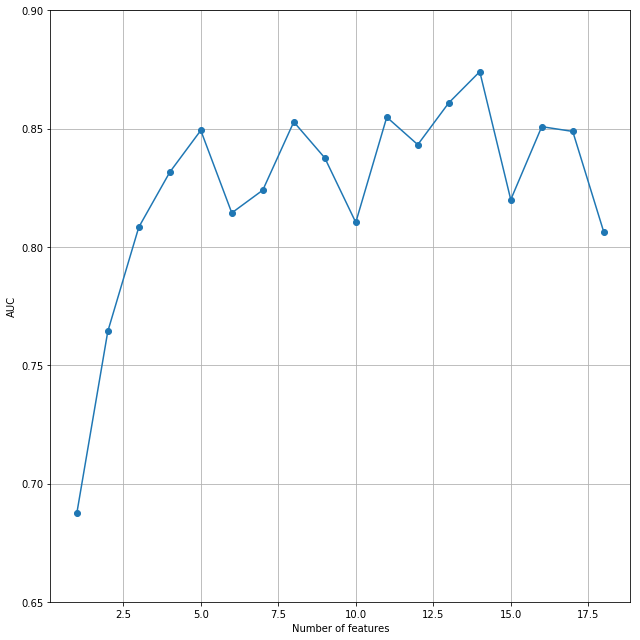

In [135]:
plt.rcParams['figure.figsize']=(9,9)
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.65, 0.9])
plt.ylabel('AUC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [136]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16),
 (0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16),
 (0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 16),
 (0, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16),
 (0, 1, 2, 3, 5, 6, 10, 11, 13, 14, 16),
 (0, 1, 2, 3, 5, 6, 10, 13, 14, 16),
 (0, 1, 2, 3, 5, 6, 10, 13, 16),
 (0, 1, 3, 5, 6, 10, 13, 16),
 (0, 1, 3, 5, 10, 13, 16),
 (0, 3, 5, 10, 13, 16),
 (0, 5, 10, 13, 16),
 (0, 5, 10, 16),
 (5, 10, 16),
 (5, 10),
 (5,)]

In [137]:
k14=list(sbs.subsets_[-14])
print(k14)

feature_labels = df2.columns[0:-1]
print (feature_labels[k14])

[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16]
Index(['age', 'sex', 't_bilirubin', 'd_bilirubin', 'alkphos', 'sgpt', 'sgot',
       'alb/glob', 'ind_bilirubin', 'sgpt_prop', 'sgot_prop', 'sgot_sgpt_prop',
       'alkphos_prop', 'glob_prop'],
      dtype='object')


In [138]:
features_selected = ['age', 'sex', 't_bilirubin', 'd_bilirubin', 'alkphos', 'sgpt', 'sgot',
                     'alb/glob', 'ind_bilirubin', 'sgpt_prop', 'sgot_prop', 'sgot_sgpt_prop',
                     'alkphos_prop', 'glob_prop', 'class']

rf_df_fsel = df2.loc[:, features_selected]
rf_df_fsel.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob_prop,class
0,65,0,0.7,0.1,187,16,18,0.90,0.6,2.352941,2.647059,5.000000,27.500000,0.539216,1
1,62,1,10.9,5.5,699,64,100,0.74,5.4,8.533333,13.333333,21.866667,93.200000,0.576577,1
2,62,1,7.3,4.1,490,60,68,0.89,3.2,8.571429,9.714286,18.285714,70.000000,0.529695,1
3,58,1,1.0,0.4,182,14,20,1.00,0.6,2.058824,2.941176,5.000000,26.764706,0.500000,1
4,72,1,3.9,2.0,195,27,59,0.40,1.9,3.698630,8.082192,11.780822,26.712329,0.821918,1


In [139]:
rf_X = np.array(rf_df_fsel.iloc[:, :-1].values)
rf_y = np.array(rf_df_fsel.iloc[:, -1].values) # class label is contained here

In [140]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=0.15, random_state=1)

In [141]:
print('Original dataset shape %s' % Counter(rf_y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
rf_X_res, rf_y_res = smote.fit_resample(rf_X_train, rf_y_train)

print('Resampled dataset shape %s' % Counter(rf_y_res))

Original dataset shape Counter({1: 314, 0: 141})
Resampled dataset shape Counter({1: 314, 0: 314})


In [142]:
rf_X_train = stdsc.fit_transform(rf_X_res)
rf_X_test = stdsc.transform(rf_X_test)

rf_y_train = rf_y_res

# Base Random Forest

In [143]:
base_rf = RandomForestClassifier(random_state=1)
base_rf.fit(rf_X_train, rf_y_train)  

base_rf_training_prediction = base_rf.predict(rf_X_train)

base_prediction_rf = base_rf.predict(rf_X_test)
base_prediction_rf

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [144]:
base_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Evaluation parameters on training data:


Accuracy: 0.9857
AUC: 0.9857
Precision: 0.9935
Recall: 0.9777
F1: 0.9856


Confusion Matrix
[[312   2]
 [  7 307]]


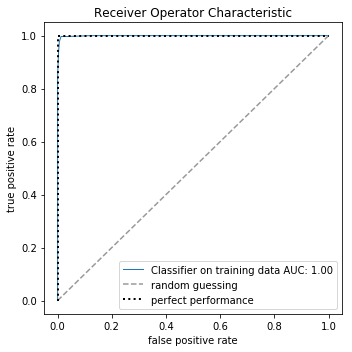

In [145]:
training_metrics(base_rf, rf_X_train, rf_y_train, base_rf_training_prediction)

Evaluation parameters on testing data:


Accuracy: 0.6420
AUC: 0.6193
Precision: 0.7755
Recall: 0.6786
F1: 0.7238


Confusion Matrix
[[14 11]
 [18 38]]


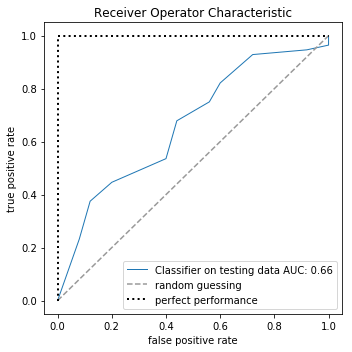

In [146]:
testing_metrics(base_rf, rf_X_test, rf_y_test, base_prediction_rf)

The Confusion Matrix shows high numbers of False Negatives, reaching counts of almost 50% of the True Positives in the testing data. For the training, the counts for each category are in line with an overfitting of the data, as expected. The ROC curve and AUC shows little generalization capabilities for the RF.

# Random Forest Hyperparameter tunning with GridsearchCV

Evaluation parameters on testing data:


Accuracy: 0.6667
AUC: 0.6261
Precision: 0.7736
Recall: 0.7321
F1: 0.7523


Confusion Matrix
[[13 12]
 [15 41]]


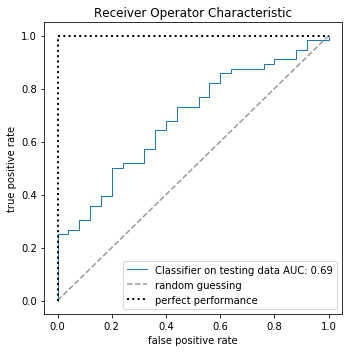

In [151]:
# Done without using best_estimator_ since the GridSearch takes hours on local laptop
best_rf  = RandomForestClassifier(class_weight = 'balanced_subsample',
                                  criterion = 'entropy',
                                  max_depth = None,
                                  max_features = 5, 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 5,
                                  min_samples_split = 5,
                                  n_estimators = 1000,
                                  oob_score = True,
                                  random_state = 1                                                               
                                 )

# best_rf1 = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

In [84]:
parameters={'n_estimators': [500, 1000, 1500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 15, 25],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2,5, 10],
            'random_state' : [1],
            'class_weight': ['balanced_subsample'],
            'oob_score': [True],
            'warm_start': [True]
            
           }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   55.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 12.0min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 21.6min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 34.7min
[Parallel(n_jobs=3)]: Done 1452 tasks      | elapsed: 52.5min
[Parallel(n_jobs=3)]: Done 1620 out of 1620 | elapsed: 59.3min finished
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the

--> Tuned Parameters Best Score:  0.8972095233203204
--> Best Parameters: 
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True, 'random_state': 1, 'warm_start': True}


Evaluation parameters on testing data:


Accuracy: 0.7037
AUC: 0.6639
Precision: 0.7963
Recall: 0.7679
F1: 0.7818


Confusion Matrix
[[14 11]
 [13 43]]


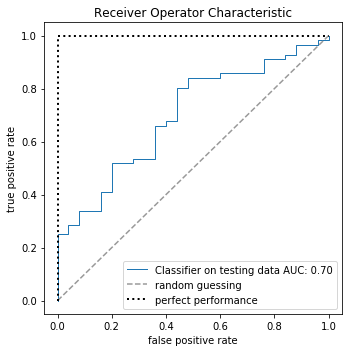

In [152]:
# Done without using best_estimator_ since the GridSearch takes hours on local laptop
best_rf  = RandomForestClassifier(class_weight = 'balanced_subsample',
                                  criterion = 'entropy',
                                  max_depth = 15,
                                  max_features = 5, 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  n_estimators = 1000,
                                  oob_score = True,
                                  random_state = 1                                                                
                                 )

# best_rf1 = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

### From this point the evaluation criteria on the test data starts to deteriorate

Evaluation parameters on testing data:


Accuracy: 0.6543
AUC: 0.6171
Precision: 0.7692
Recall: 0.7143
F1: 0.7407


Confusion Matrix
[[13 12]
 [16 40]]


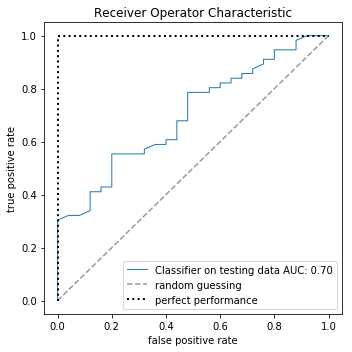

In [153]:
# Done without using best_estimator_ since the GridSearch takes hours on local laptop
best_rf  = RandomForestClassifier(class_weight = 'balanced_subsample',
                                  criterion = 'entropy',
                                  max_depth = 25,
                                  max_features = 1, 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  n_estimators = 500,
                                  oob_score = True,
                                  random_state = 1                                                                
                                 )

# best_rf1 = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

In [ ]:
parameters={'n_estimators': [400, 500, 750],
            'criterion': ['entropy'],
            'max_depth': [15, 20, 25, 30],
            'min_samples_leaf': [1, 3, 5],
            'min_samples_split': [2, 3, 5],
            'random_state' : [1],
            'class_weight': ['balanced_subsample'],
            'oob_score': [True],
            'warm_start': [True],
             'max_features': [1,2, 3, 5 , 10]
            
           }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=-1,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

### Same scoring as before

In this case the optimization steps did show an over fitting to the data, since ROC-AUC score used to track the estimator in the grid search with cross-validation kept giving better results in each iteration but the evaluation criteria for the testing set reached a maximum and then started to deteriorate.

### Sensitivity analysis for the optmized Random Forest

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Evaluation parameters on testing data:


Accuracy: 0.6667
AUC: 0.6371
Precision: 0.7843
Recall: 0.7143
F1: 0.7477


Confusion Matrix
[[14 11]
 [16 40]]


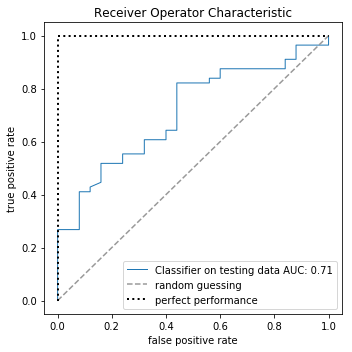

In [154]:
sens_rf = RandomForestClassifier(n_estimators = 100,
                                class_weight = 'balanced_subsample', 
                                criterion = 'entropy', 
                                max_depth = 15, 
                                min_samples_leaf = 1,
                                min_samples_split = 2,
                                oob_score = True,
                                warm_start = True,
                                random_state = 1)

# best_rf1 = gs_rfc.best_estimator_

sens_rf.fit(rf_X_train, rf_y_train)  

sens_rf_prediction = sens_rf.predict(rf_X_test)

testing_metrics(sens_rf, rf_X_test, rf_y_test, sens_rf_prediction)

Evaluation parameters on testing data:


Accuracy: 0.6420
AUC: 0.6414
Precision: 0.8000
Recall: 0.6429
F1: 0.7129


Confusion Matrix
[[16  9]
 [20 36]]


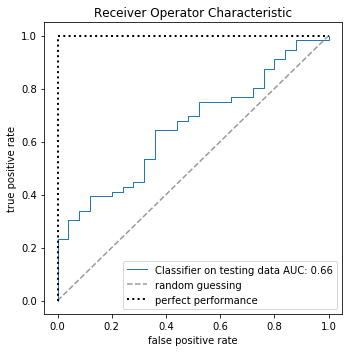

In [156]:
sens_rf = RandomForestClassifier(n_estimators = 1000,
                                class_weight = 'balanced_subsample', 
                                criterion = 'entropy', 
                                max_depth = 5, 
                                min_samples_leaf = 1,
                                min_samples_split = 2,
                                oob_score = True,
                                random_state = 1)

sens_rf.fit(rf_X_train, rf_y_train)  

sens_rf_prediction = sens_rf.predict(rf_X_test)

testing_metrics(sens_rf, rf_X_test, rf_y_test, sens_rf_prediction)

Modifying parameters corresponding to the number of trees per RF and the maximum depth of a tree to a lower order of magnitude shows how impactful these factors are when creating a RF algorithm. Diminishing the number of trees has impact on the robustness of the model, since there are less estimators with variability to create the ensemble. This is reflected in how every criteria deteriorates with a smaller number of trees. The confusion matrix shows one more sample was added to the False Negatives group, giving a worse error rate. Interestingly, the ROC-AUC slightly improves to 0.71. This could mean that probabilities get slightly better, but since the test set has a small number of samples it could be factor affecting how the criteria is calculated.

Changing the max depth of the trees worsens all criteria but Precision, which reaches 0.80. Nevertheless, in a medical context this wouldn’t be so critical, since non-patients being diagnosed as positive wouldn’t be at risk. The Recall remains remains low, as the so do the other criteria

# Random forest including outliers

## Feature Selection

In [71]:
df.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767,1


In [72]:
pd.options.mode.chained_assignment = None  # default='warn' . In this case there is no need to worry about SettingWithCopyWarning

df['ind_bilirubin']  = df.apply(lambda row: row.t_bilirubin - row.d_bilirubin, axis=1)
df['sgpt_prop']      = df.apply(lambda row: row.sgpt / row.t_protein, axis=1)
df['sgot_prop']      = df.apply(lambda row: row.sgot / row.t_protein, axis=1)
df['sgot_sgpt_prop'] = df.apply(lambda row: (row.sgpt + row.sgot) / row.t_protein, axis=1)
df['alkphos_prop']   = df.apply(lambda row: row.alkphos / row.t_protein, axis=1)
df['glob']           = df.apply(lambda row: row.alb / row["alb/glob"], axis=1)
df['glob_prop']      = df.apply(lambda row: row["glob"] / row.t_protein, axis=1)
df['alb_prop']       = df.apply(lambda row: row.alb / row.t_protein, axis=1)

In [73]:
df.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767,1


In [74]:
# Pushes Class column to the end of the dataframe for easier indexing
col_at_end = ['class']
df = df[[c for c in df if c not in col_at_end] 
        + [c for c in col_at_end if c in df]]
df.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,sgpt,sgot,t_protein,alb,alb/glob,ind_bilirubin,sgpt_prop,sgot_prop,sgot_sgpt_prop,alkphos_prop,glob,glob_prop,alb_prop,class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,0.6,2.352941,2.647059,5.000000,27.500000,3.666667,0.539216,0.485294,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,5.4,8.533333,13.333333,21.866667,93.200000,4.324324,0.576577,0.426667,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,3.2,8.571429,9.714286,18.285714,70.000000,3.707865,0.529695,0.471429,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0.6,2.058824,2.941176,5.000000,26.764706,3.400000,0.500000,0.500000,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.9,3.698630,8.082192,11.780822,26.712329,6.000000,0.821918,0.328767,1


In [75]:
# transfer new data into new X and y arrays

X = np.array(df.iloc[:, :-1].values)
y = np.array(df.iloc[:, -1].values) # class label is contained here

np.mean(y), np.std(y), np.var(y)  

(0.7135506003430532, 0.45210191449840326, 0.20439614109312151)

### Data split into training and test sets

In [76]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(X, y, test_size=0.15, random_state=1)

### Oversampling the minority class of the training set with SMOTE

In [77]:
print('Original dataset shape %s' % Counter(rf_y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
rf_X_res, rf_y_res = smote.fit_resample(rf_X_train, rf_y_train)
              
print('Resampled dataset shape %s' % Counter(rf_y_res))

Original dataset shape Counter({1: 349, 0: 146})
Resampled dataset shape Counter({1: 349, 0: 349})


### Data scaling. First on training data, and using that information to scale the test data.

In [78]:
stdsc = StandardScaler()

rf_X_train = stdsc.fit_transform(rf_X_res)
rf_X_test = stdsc.transform(rf_X_test)

In [79]:
rf_y_train = rf_y_res

In [80]:
rf = RandomForestClassifier(random_state=1)

# selecting features
sbs = SBS(rf, k_features=1)
sbs.fit(rf_X_train, rf_y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]



c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


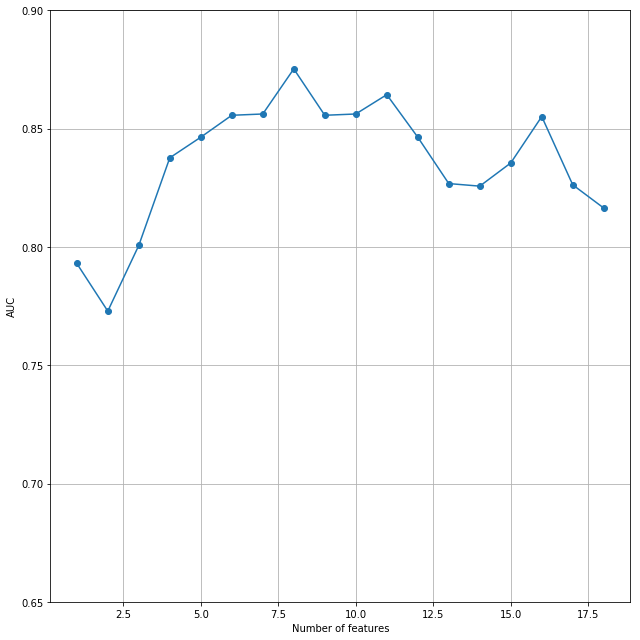

In [81]:
plt.rcParams['figure.figsize']=(9,9)
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.65, 0.9])
plt.ylabel('AUC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [82]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16),
 (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16),
 (0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 14, 16),
 (0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 14, 16),
 (0, 1, 2, 3, 4, 7, 8, 9, 11, 14, 16),
 (0, 1, 2, 3, 4, 7, 8, 9, 11, 14),
 (0, 1, 2, 3, 4, 7, 9, 11, 14),
 (0, 1, 2, 3, 4, 7, 11, 14),
 (1, 2, 3, 4, 7, 11, 14),
 (1, 2, 3, 4, 7, 11),
 (1, 2, 4, 7, 11),
 (1, 2, 4, 7),
 (1, 2, 4),
 (1, 2),
 (2,)]

In [83]:
k8=list(sbs.subsets_[-8])
print(k8)

feature_labels = df.columns[0:-1]
print(feature_labels[k8])

[0, 1, 2, 3, 4, 7, 11, 14]
Index(['age', 'sex', 't_bilirubin', 'd_bilirubin', 'alkphos', 't_protein',
       'sgpt_prop', 'alkphos_prop'],
      dtype='object')


In [84]:
features_selected = ['age', 'sex', 't_bilirubin', 'd_bilirubin', 'alkphos', 't_protein',
       'sgpt_prop', 'alkphos_prop', 'class']

rf_df_fsel = df.loc[:, features_selected]
rf_df_fsel.head()

,age,sex,t_bilirubin,d_bilirubin,alkphos,t_protein,sgpt_prop,alkphos_prop,class
0,65,0,0.7,0.1,187,6.8,2.352941,27.500000,1
1,62,1,10.9,5.5,699,7.5,8.533333,93.200000,1
2,62,1,7.3,4.1,490,7.0,8.571429,70.000000,1
3,58,1,1.0,0.4,182,6.8,2.058824,26.764706,1
4,72,1,3.9,2.0,195,7.3,3.698630,26.712329,1


In [85]:
rf_X = np.array(rf_df_fsel.iloc[:, :-1].values)
rf_y = np.array(rf_df_fsel.iloc[:, -1].values) # class label is contained here

In [86]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=0.15, random_state=1)

In [87]:
print('Original dataset shape %s' % Counter(rf_y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
rf_X_res, rf_y_res = smote.fit_resample(rf_X_train, rf_y_train)

print('Resampled dataset shape %s' % Counter(rf_y_res))

Original dataset shape Counter({1: 349, 0: 146})
Resampled dataset shape Counter({1: 349, 0: 349})


In [88]:
rf_X_train = stdsc.fit_transform(rf_X_res)
rf_X_test = stdsc.transform(rf_X_test)

rf_y_train = rf_y_res

# Base Random Forest with outliers

In [45]:
base_rf = RandomForestClassifier(random_state=1)
base_rf.fit(rf_X_train, rf_y_train)  

base_rf_training_prediction = base_rf.predict(rf_X_train)

base_prediction_rf = base_rf.predict(rf_X_test)
base_prediction_rf

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [46]:
base_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Evaluation parameters on training data:


Accuracy: 0.9871
AUC: 0.9871
Precision: 0.9971
Recall: 0.9771
F1: 0.9870


Confusion Matrix
[[348   1]
 [  8 341]]


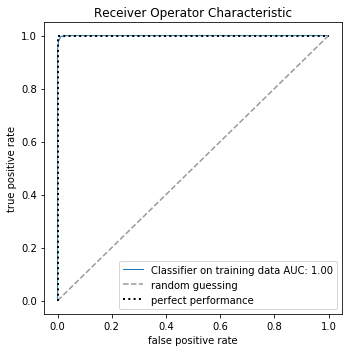

In [50]:
training_metrics(base_rf, rf_X_train, rf_y_train, base_rf_training_prediction)

Evaluation parameters on testing data:


Accuracy: 0.7273
AUC: 0.6738
Precision: 0.8525
Recall: 0.7761
F1: 0.8125


Confusion Matrix
[[12  9]
 [15 52]]


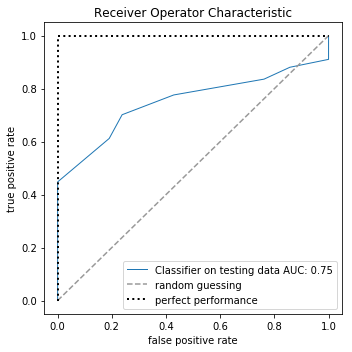

In [51]:
testing_metrics(base_rf, rf_X_test, rf_y_test, base_prediction_rf)

# Random Forest Hyperparameter tunning with GridsearchCV with outliers

In [52]:
parameters={'n_estimators': [500, 1000],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5],
            'min_samples_leaf': [5, 15],
            'min_samples_split': [5, 15],            
            'class_weight' : ['balanced', 'balanced_subsample',  None],
            'max_features': ['auto', 5 ],
            'max_leaf_nodes' : [None, 5],
            'oob_score' : [True, False],
            'warm_start': [True, False],
            'random_state' : [1],
             }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=-1,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

Fitting 10 folds for each of 1536 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 88.3min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done 9105 tasks      |

--> Tuned Parameters Best Score:  0.8719679275721749
--> Best Parameters: 
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000, 'oob_score': True, 'random_state': 1, 'warm_start': True}


Evaluation parameters on testing data:


Accuracy: 0.6932
AUC: 0.6187
Precision: 0.8226
Recall: 0.7612
F1: 0.7907


Confusion Matrix
[[10 11]
 [16 51]]


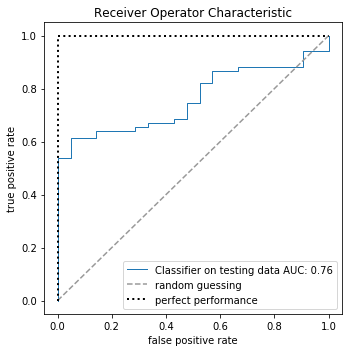

In [54]:
# Done without using best_estimator_ since the GridSearch takes hours on local laptop
best_rf  = RandomForestClassifier(class_weight = 'balanced',
                                  criterion = 'entropy',
                                  max_depth = None,
                                  max_features = 'auto', 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 5,
                                  min_samples_split = 5,
                                  n_estimators = 1000,
                                  oob_score = True,
                                  random_state = 1                                                               
                                 )

# best_rf1 = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

In [55]:
parameters={'n_estimators': [500, 1000, 1500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 15, 25],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2,5, 10],
            'random_state' : [1],
            'class_weight': ['balanced_subsample'],
            'oob_score': [True],
            'warm_start': [True]
            
           }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  5.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 11.6min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 21.1min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 35.2min
[Parallel(n_jobs=3)]: Done 1452 tasks      | elapsed: 57.0min
[Parallel(n_jobs=3)]: Done 1620 out of 1620 | elapsed: 64.3min finished
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the

--> Tuned Parameters Best Score:  0.8998808119236235
--> Best Parameters: 
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'oob_score': True, 'random_state': 1, 'warm_start': True}


c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Evaluation parameters on testing data:


Accuracy: 0.7159
AUC: 0.6173
Precision: 0.8182
Recall: 0.8060
F1: 0.8120


Confusion Matrix
[[ 9 12]
 [13 54]]


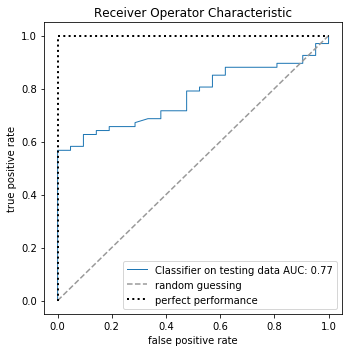

In [90]:
best_rf  = RandomForestClassifier(class_weight = 'balanced_subsample',
                                  criterion = 'entropy',
                                  max_depth = 25,
                                  max_features = 'auto', 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  n_estimators = 500,
                                  oob_score = True,
                                  random_state = 1,
                                  warm_start=True
                                 )

#best_rf = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

In [56]:
parameters={'n_estimators': [500, 1000, 1500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 15, 25],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2,5, 10],
            'random_state' : [1],
            'class_weight': ['balanced'],
            'oob_score': [True],
            'warm_start': [True]
            
           }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   41.6s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 12.7min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 21.9min
[Parallel(n_jobs=3)]: Done 1452 tasks      | elapsed: 33.6min
[Parallel(n_jobs=3)]: Done 1620 out of 1620 | elapsed: 39.1min finished
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the

--> Tuned Parameters Best Score:  0.8995653848932124
--> Best Parameters: 
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500, 'oob_score': True, 'random_state': 1, 'warm_start': True}


c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Evaluation parameters on testing data:


Accuracy: 0.7159
AUC: 0.6173
Precision: 0.8182
Recall: 0.8060
F1: 0.8120


Confusion Matrix
[[ 9 12]
 [13 54]]


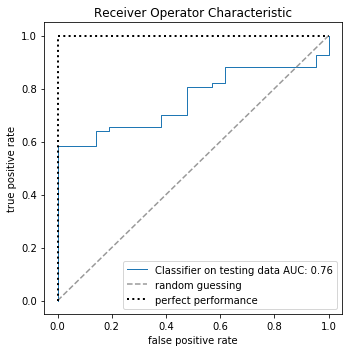

In [91]:
# Done without using best_estimator_ since the GridSearch takes hours on local laptop
best_rf  = RandomForestClassifier(class_weight = 'balanced',
                                  criterion = 'entropy',
                                  max_depth = None,
                                  max_features = 'auto', 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  n_estimators = 1500,
                                  oob_score = True,
                                  random_state = 1,
                                  warm_start=True
                                 )

# best_rf1 = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

In [58]:
parameters={'n_estimators': [250, 500, 750, 1000],
            'criterion': ['entropy'],
            'max_depth': [20, 25, 30],
            'min_samples_leaf': [1,2,3],
            'min_samples_split': [2,3,4],
            'random_state' : [1],
            'class_weight': ['balanced_subsample'],
            'oob_score': [True],
            'warm_start': [False]
            
           }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  8.0min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 14.5min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 23.5min
[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed: 25.1min finished


--> Tuned Parameters Best Score:  0.9003238544701548
--> Best Parameters: 
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750, 'oob_score': True, 'random_state': 1, 'warm_start': False}


Evaluation parameters on testing data:


Accuracy: 0.7273
AUC: 0.6247
Precision: 0.8209
Recall: 0.8209
F1: 0.8209


Confusion Matrix
[[ 9 12]
 [12 55]]


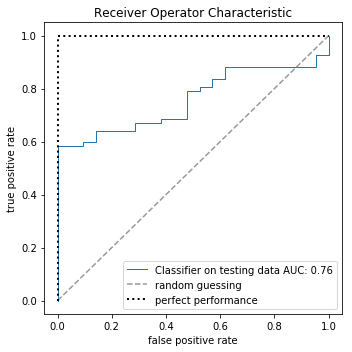

In [59]:

'''best_rf  = RandomForestClassifier(class_weight = 'balanced_subsample',
                                  criterion = 'entropy',
                                  max_depth = 25,
                                  max_features = 'auto', 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  n_estimators = 500,
                                  oob_score = True,
                                  random_state = 1                                                               
                                 )'''

best_rf = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

### Optimized evaluation criteria has been reached.

In [60]:
parameters={'n_estimators': [650, 750, 850],
            'criterion': ['entropy'],
            'max_depth': [ 25, 30, 35, 40],
            'min_samples_leaf': [1,2],
            'min_samples_split': [2,3],
            'random_state' : [1],
            'class_weight': ['balanced_subsample'],
            'oob_score': [True],
            'warm_start': [False]
            
           }

gs_rfc = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = parameters,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

gs_rfc = gs_rfc.fit(rf_X_train, rf_y_train)
print('--> Tuned Parameters Best Score: ',gs_rfc.best_score_)
print('--> Best Parameters: \n',gs_rfc.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   47.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  9.9min
[Parallel(n_jobs=3)]: Done 480 out of 480 | elapsed: 13.5min finished


--> Tuned Parameters Best Score:  0.9003238544701548
--> Best Parameters: 
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750, 'oob_score': True, 'random_state': 1, 'warm_start': False}


Evaluation parameters on testing data:


Accuracy: 0.7273
AUC: 0.6247
Precision: 0.8209
Recall: 0.8209
F1: 0.8209


Confusion Matrix
[[ 9 12]
 [12 55]]


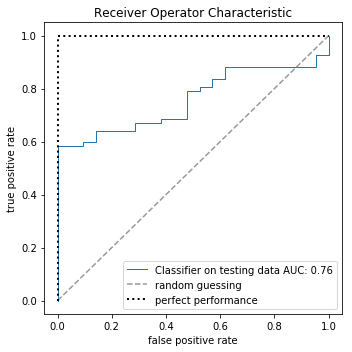

In [89]:
best_rf  = RandomForestClassifier(class_weight = 'balanced_subsample',
                                  criterion = 'entropy',
                                  max_depth = 30,
                                  max_features = 'auto', 
                                  max_leaf_nodes = None,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  n_estimators = 750,
                                  oob_score = True,
                                  random_state = 1,
                                  warm_start=False
                                 )

#best_rf = gs_rfc.best_estimator_

best_rf.fit(rf_X_train, rf_y_train)  

best_rf_prediction = best_rf.predict(rf_X_test)

testing_metrics(best_rf, rf_X_test, rf_y_test, best_rf_prediction)

### Is it better with or without outliers?

The inclusion of the outlier data improves the generalisation capabilities of the Random Forest. 

* Accuracy improves from 0.70 to 0.73.
* Precision improves from 0.80 to 0.82.
* Recall improves from 0.77 to 0.82.
* F1-score improves from 0.78 to 0.82.
* AUC score based on data deteriorates from 0.66 to 0.62, but based on probablities (graph) improves from 0.70 to 0.76.

The inclusion of the outlier data improves the classification properties of the Random Forest.

# Discussion and Conclusion

SVM results from Ramana et al (5) contrasts highly with the ones obtained in this work, reaching very high scores in every evaluation criteria used. As an example, their highest Accuracy score was of 97.86% for the first 5 features ordered by importance. This great difference against the results obtained here suggests that there could be issues with their data preprocessing like class rebalancing, feature scaling or the proportion of training and test data after splitting, since there is no mention of these steps in their work.

With respect to results obtained with RF algorithms, Pahareeya et al (9) reached high levels of accuracy by oversampling the minority class by 200%, resulting in a score of 89.12% in contrast with the 67.9% achieved in this work. Nevertheless, it seems that this oversampling was done before a data split, which could create data leakage.

In this work, a high number of false negatives was obtained with both optimized SVM and RF algorithms. This is not acceptable in a medical context, since these incorrectly classified patients would be at risk of being overlooked by medical professionals and develop a more advanced liver disease. To deal with this issue a number of alternatives arise. For example, the class imbalances could be dealt in a different manner, not trying to reach a 1:1 ratio between patients and non-patients with synthetic samples, but this could affect the evaluation since the algorithm shouldn’t be exposed to balanced testing data. An alternative to this is to undersampling the majority class, but since there are already a small number of instances to work with, this option could cause issues in the training. An option is to gather more data from non-patients to balance the dataset, and from this point generate a new classification model.

It has to be said that this dataset is relatively small, so the proportion of data between training and testing sets could affect the results since small test sets can create bias in results obtained. It’s possible that a 85%-15% split is not optimal, and other proportions would need to be explored. 
	
Other classification algorithms could be optimized for the dataset, and it’s possible to create an ensemble of these optimized classifiers to obtain better results.

The potential for deployment of an algorithm to facilitate the diagnosis of liver disease could be of high impact in zones where access to medical professionals is limited, be it in developing countries or where demand for endocrinologists highly surpasses the delivering capabilities of health institutions. But as Ramana et al write (10) there are differences between populations that could be crucial, so it is possible that a trained algorithm that works with high accuracy in one population could struggle in another one. This could be because of intrinsic characteristics of the underlying population.

   The inclusion of the outlier data into the training of both algorithms improved their generalization capabilities, but more for the Random Forest than for the Support Vector Machine. This is of note since normally outlier data is associated with errors in measurement and tends to be discarded. In the studied case, outliers provided important information to both algorithms and suggests that could be relevant for other uses.

Two optimized classification algorithms were presented in this work, but they didn’t reached a level where is feasible to apply them in a real setting, and more alternatives need to be explored.

	
		
# References

1. Liver function tests: MedlinePlus Medical Encyclopedia". www.nlm.nih.gov. Retrieved 7-5-2019.

2. Liver disease – NHS Choices. www.nhs.uk. Retrieved 7-5-2019.

3. Ramana.  ILPD (Indian Liver Patient Dataset) Data Set. Department of Information Technology, Aditya Instutute of Technology and Management, Tekkali - 532201, Andhra Pradesh, India.  http://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29#

4. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

5.  Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, A Critical Study of Selected Classification Algorithms for Liver Disease Diagnosis, International Journal of Database Management Systems (IJDMS), Vol.3, No.2, ISSN: 0975-5705, PP 101-114, May 2011.

6. N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 321-357, 2002.

7. Cortes, C., Vapnik, V., Support-Vector Networks.  Machine Learning, 20, 273-297 (1995).

8. Breiman, L., Random Forests. Machine Learning, 45, 5–32, (2001).

9. Pahareeya, J., Vohra R., Makhijani J., Patsariya S. Liver Patient Classification using Intelligence Techniques. International Journal of Advanced Research in Computer Science and Software Engineering. Volume 4, Issue 2, February 2014.

10. Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis, International Journal of Computer Science Issues, ISSN :1694-0784, May 2012.

11. Pedersen, R., & Schoeberl, M. (2006). An Embedded Support Vector Machine. In Proceedings of the Fourth Workshop on Intelligent Solutions in Embedded Systems (WISES 2006) (pp. 79-89)

12. Bernstein, M., Random Forests, Computer Science Department, University of Wisconsin.  http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/ensembles/RandomForests.pdf